In [1]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [2]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [3]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [4]:
symbol = 'BTC/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [5]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [42]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

In [43]:
df_ind = df_ind.iloc[25:]


### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver4.0 y el notebook es red_neuronal_mlp.ipynb


In [ ]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver4.0')
from volting_classifier_model import ensemble_clf, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind =df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

X_nuevos =df_ind[features]

# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

# Realizar predicciones en los nuevos datos
predicciones = ensemble_clf.predict(X_nuevos_scaled)

df_df_ind["predicted_signals"] = predicciones


In [57]:
import numpy as np

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predicted_signals'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predicted_signals'] == 'sell', 1, 0)


In [58]:
df_df_ind.head()

,date,open,high,low,close,volume,value,value_classification,rsi,macd,...,vwap,predicted_signals,buy_signal,sell_signal,daily_return,capital,capital_simulado,capital_max,drawdown,drawdown_pct
50,2022-08-25,21366.01,21811.00,21312.51,21563.81,1602.992599,25,Extreme Fear,36.800006,-541.743798,...,22516.864352,buy,1,0,-0.007110,1059.068074,1000,1000,0,0.0
51,2022-08-26,21563.81,21868.78,20115.00,20244.11,4770.011922,27,Fear,27.946082,-649.685275,...,22193.048053,hold,0,0,0.009258,1068.872603,1000,1000,0,0.0
52,2022-08-27,20244.11,20371.80,19799.00,20043.30,2887.359237,28,Fear,26.886072,-742.870020,...,21927.799786,hold,0,0,-0.061200,1003.457856,1000,1000,0,0.0
53,2022-08-28,20043.30,20158.75,19526.89,19555.66,1754.101490,28,Fear,24.459794,-846.312312,...,21712.364414,hold,0,0,-0.009919,993.504128,1000,1000,0,0.0
54,2022-08-29,19555.66,20427.41,19553.08,20293.48,2705.206325,24,Extreme Fear,34.143618,-858.854822,...,21399.420030,hold,0,0,-0.024329,969.332841,1000,1000,0,0.0


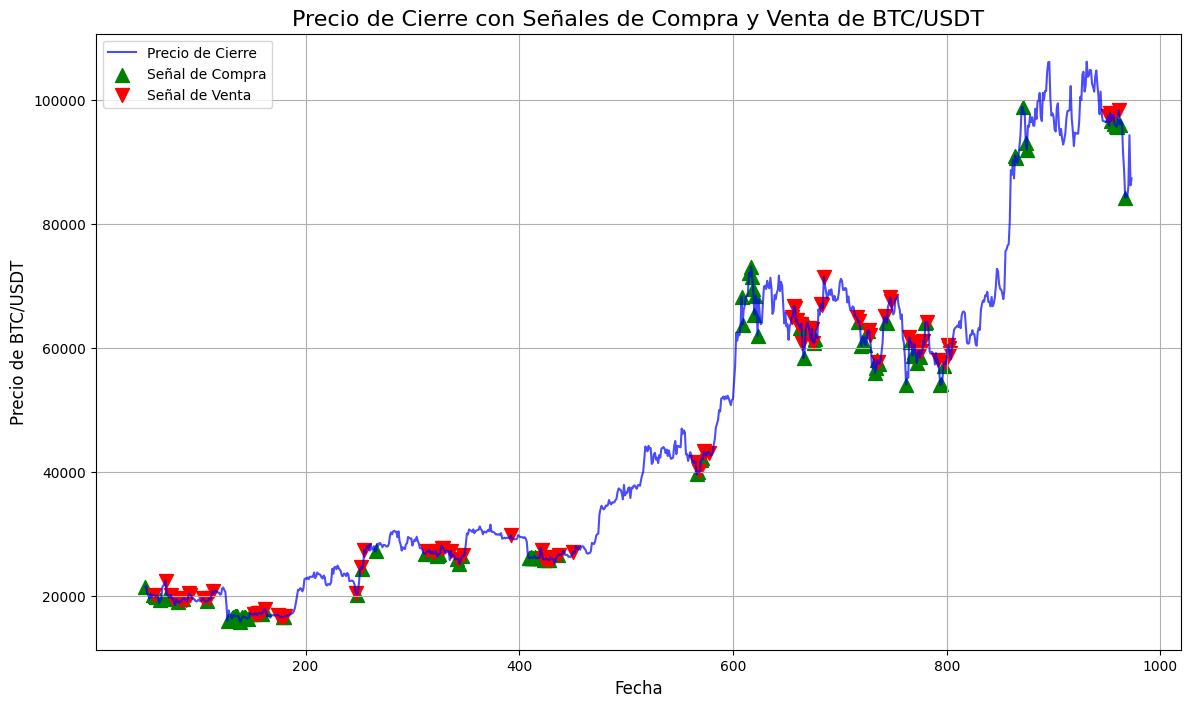

In [59]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title(f'Precio de Cierre con Señales de Compra y Venta de {symbol}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {symbol}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a 21366.01 en 2022-08-25 00:00:00
Venta a 20133.28 en 2022-09-02 00:00:00 | ROI: -5.77%
Compra a 19955.34 en 2022-09-03 00:00:00
Venta a 22394.49 en 2022-09-13 00:00:00 | ROI: 12.22%
Compra a 20172.78 en 2022-09-14 00:00:00
Venta a 20112.0 en 2022-09-18 00:00:00 | ROI: -0.30%
Compra a 19416.95 en 2022-09-19 00:00:00
Venta a 19535.58 en 2022-09-20 00:00:00 | ROI: 0.61%
Compra a 19397.79 en 2022-09-23 00:00:00
Venta a 19225.7 en 2022-09-27 00:00:00 | ROI: -0.89%
Compra a 19413.5 en 2022-09-29 00:00:00
Venta a 19591.57 en 2022-09-30 00:00:00 | ROI: 0.92%
Compra a 19163.1 en 2022-10-22 00:00:00
Venta a 19569.0 en 2022-10-24 00:00:00 | ROI: 2.12%
Compra a 15910.69 en 2022-11-10 00:00:00
Venta a 17105.45 en 2022-12-05 00:00:00 | ROI: 7.51%
Compra a 16963.99 en 2022-12-06 00:00:00
Venta a 17084.99 en 2022-12-07 00:00:00 | ROI: 0.71%
Compra a 17089.8 en 2022-12-12 00:00:00
Venta a 17804.08 en 2022-12-15 00:00:00 | ROI: 4.18%
Compra a 16541.8 en 2023-01-01 00:00:00
Venta a 16675.59 en 20

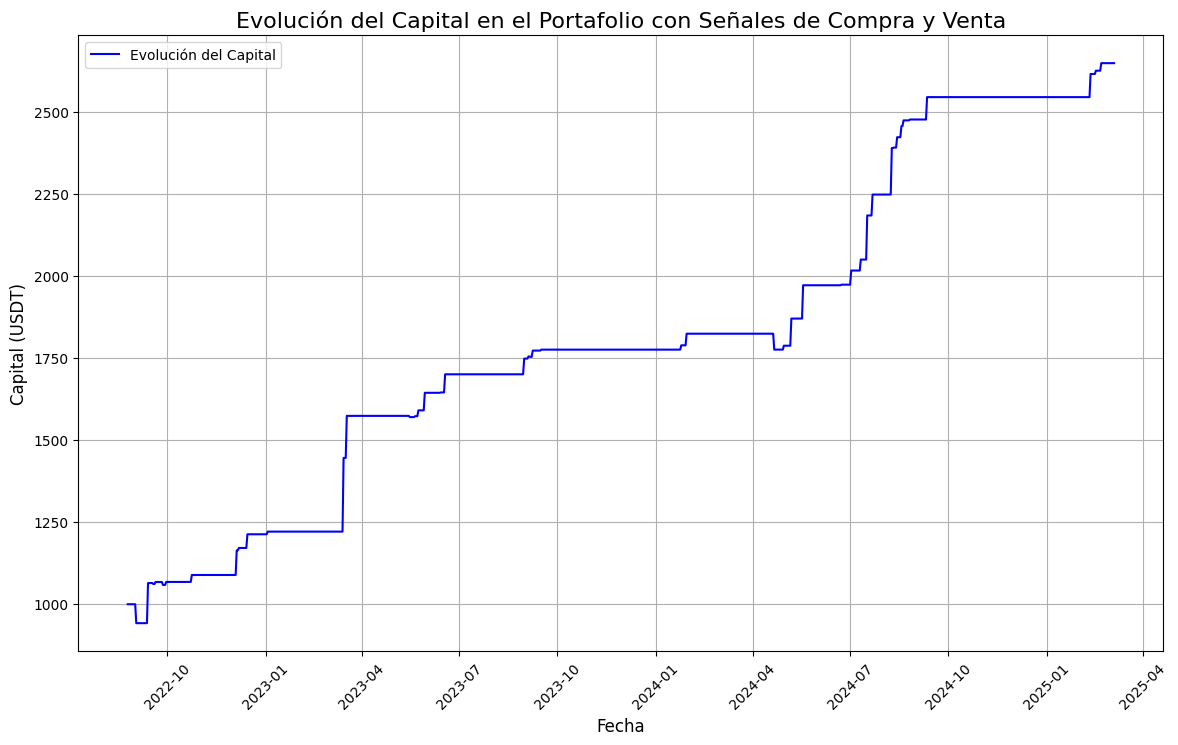

In [60]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 125363.79 USDT
Tasa de Retorno Acumulado: 12436.38%
Volatilidad Anualizada: 0.4147
Relación de Sharpe: -0.0196
Drawdown Máximo: -32.48%


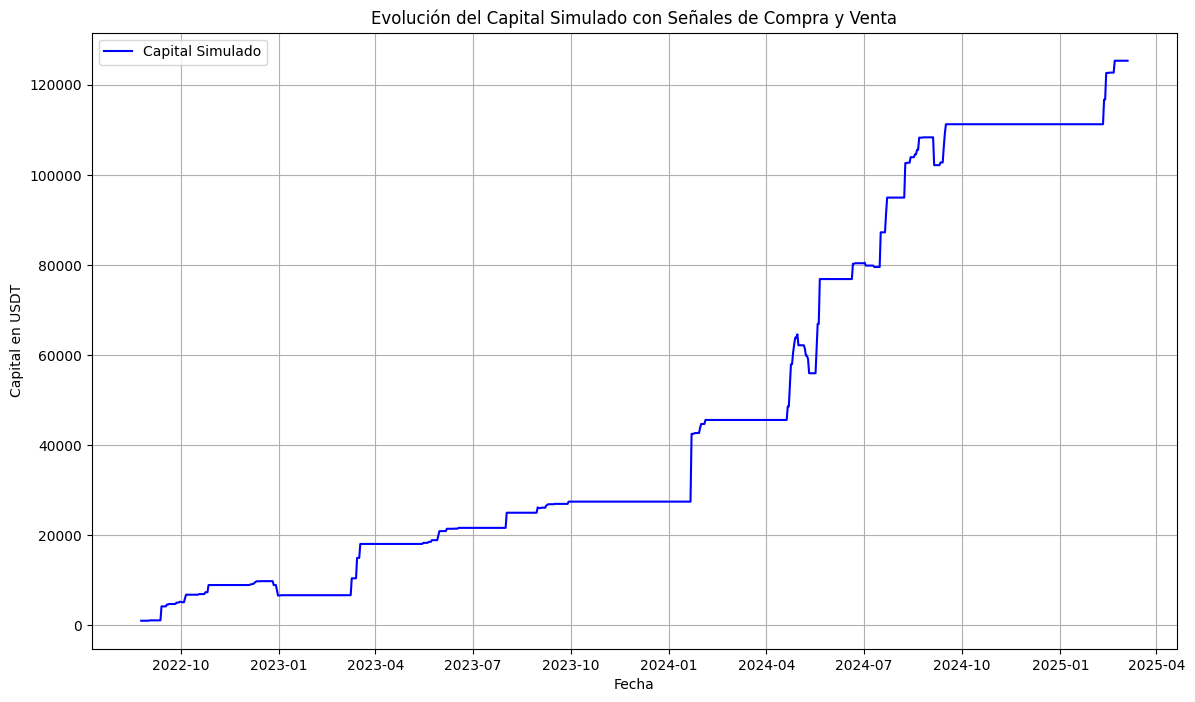

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [63]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Compra a 21368.15 en 2022-08-25 00:00:00
Venta a 20118.18 en 2022-09-02 00:00:00 | ROI: -5.85%
Compra a 19957.34 en 2022-09-03 00:00:00
Venta a 22377.69 en 2022-09-13 00:00:00 | ROI: 12.13%
Compra a 20174.80 en 2022-09-14 00:00:00
Venta a 20096.92 en 2022-09-18 00:00:00 | ROI: -0.39%
Compra a 19418.89 en 2022-09-19 00:00:00
Venta a 19520.93 en 2022-09-20 00:00:00 | ROI: 0.53%
Compra a 19399.73 en 2022-09-23 00:00:00
Venta a 19211.28 en 2022-09-27 00:00:00 | ROI: -0.97%
Compra a 19415.44 en 2022-09-29 00:00:00
Venta a 19576.88 en 2022-09-30 00:00:00 | ROI: 0.83%
Compra a 19165.02 en 2022-10-22 00:00:00
Venta a 19554.32 en 2022-10-24 00:00:00 | ROI: 2.03%
Compra a 15912.28 en 2022-11-10 00:00:00
Venta a 17092.62 en 2022-12-05 00:00:00 | ROI: 7.42%
Compra a 16965.69 en 2022-12-06 00:00:00
Venta a 17072.18 en 2022-12-07 00:00:00 | ROI: 0.63%
Compra a 17091.51 en 2022-12-12 00:00:00
Venta a 17790.73 en 2022-12-15 00:00:00 | ROI: 4.09%
Compra a 16543.45 en 2023-01-01 00:00:00
Venta a 16663.0